In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import time
import seaborn as sns
sns.set()

In [2]:
dataset = pd.read_csv('HistoricalQuotes.csv')
del dataset['date']
del dataset['volume']
dataset.head()

,close,open,high,low
0,144.77,143.25,144.89,143.17
1,144.77,143.25,144.89,143.17
2,143.70,143.71,144.12,143.05
3,143.66,143.72,144.27,143.01
4,143.93,144.19,144.50,143.50


In [3]:
count = 0; temp = dataset.iloc[0, 0]
while temp > 10:
    temp /= 10.0; count += 1
count = 10.0 ** count

stockvals = dataset.iloc[:, :].values / count
stockvals

array([[ 1.4477,  1.4325,  1.4489,  1.4317],
       [ 1.4477,  1.4325,  1.4489,  1.4317],
       [ 1.437 ,  1.4371,  1.4412,  1.4305],
       ..., 
       [ 1.1096,  1.1023,  1.1098,  1.092 ],
       [ 1.0981,  1.0951,  1.1073,  1.0942],
       [ 1.1112,  1.1042,  1.1219,  1.1027]])

In [4]:
class Model:
    def __init__(self, learning_rate, num_layers, size, size_layer):
        
        def lstm_cell():
            return tf.nn.rnn_cell.LSTMCell(size_layer, state_is_tuple = False)
        
        self.rnn_cells = tf.nn.rnn_cell.MultiRNNCell([lstm_cell() for _ in xrange(num_layers)], state_is_tuple = False)
        
        self.X = tf.placeholder(tf.float32, (None, None, size))
        self.Y = tf.placeholder(tf.float32, (None, None, size))
        
        self.hidden_layer = tf.placeholder(tf.float32, (None, num_layers * 2 * size_layer))
        self.outputs, self.last_state = tf.nn.dynamic_rnn(self.rnn_cells, self.X, initial_state = self.hidden_layer, dtype = tf.float32)
        
        self.rnn_W = tf.Variable(tf.random_normal((size_layer, size)))
        self.rnn_B = tf.Variable(tf.random_normal((size,)))
        
        outputs_reshaped = tf.reshape(self.outputs, [-1, size_layer])
        y_batch_long = tf.reshape(self.Y, [-1, size])
        
        self.logits = (tf.matmul(outputs_reshaped, self.rnn_W) + self.rnn_B)
        
        self.cost = tf.square(y_batch_long - self.logits)
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(self.cost)

In [5]:
def visualize_stock(stockvals, modelnn, num_layers, size_layer):

    current_palette = sns.color_palette("Paired", 8)

    day, day_future, data = [], [], []
    data.append(stockvals[0, :]); day.append(0); day_future.append(0)

    init_value = np.zeros((1, num_layers * 2 * size_layer))
    
    # predict 10 days forward
    for x in xrange(stockvals.shape[0] + 10):
        batch = np.zeros((1, 1, stockvals.shape[1]))
        try:
            batch[0, :, :] = stockvals[x: x + 1, :]
            day_future.append(x + 1)
            day.append(x + 1)
        except:
            batch[0, :, :] = probs[0, :]
            day_future.append(x + 1)
        
        last_state, probs = sess.run([modelnn.last_state, modelnn.logits], feed_dict={modelnn.X: batch, modelnn.hidden_layer: init_value})
        init_value = last_state
        data.append(probs[0, :].tolist())
        

    fig = plt.figure(figsize = (10,10))

    ax = plt.subplot(111)
    
    x_true = stockvals
    x_predict = np.array(data)

    ax.plot(day[:-1], x_true[:, 0], label = 'true close', color = current_palette[0])
    ax.plot(day_future, x_predict[:, 0], label = 'predict close', color = current_palette[1])
    
    ax.plot(day[:-1], x_true[:, 1], label = 'true open', color = current_palette[2])
    ax.plot(day_future, x_predict[:, 1], label = 'predict close', color = current_palette[3])
    
    ax.plot(day[:-1], x_true[:, 2], label = 'true high', color = current_palette[4])
    ax.plot(day_future, x_predict[:, 2], label = 'predict close', color = current_palette[5])
    
    ax.plot(day[:-1],x_true[:, 3], label = 'true low', color = current_palette[6])
    ax.plot(day_future, x_predict[:, 3], label = 'predict close', color = current_palette[7])
    
    box = ax.get_position()
    ax.set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9])

    ax.legend(loc = 'upper center', bbox_to_anchor= (0.5, -0.05), fancybox = True, shadow = True, ncol = 5)

    plt.title('stock market')
    plt.xlabel('day')
    plt.ylabel('value')
    plt.show()

In [6]:
num_layers = 2
size_layer = 128
epoch = 1000
sess = tf.InteractiveSession()
modelnn = Model(0.001, num_layers, stockvals.shape[1], size_layer)
sess.run(tf.global_variables_initializer())

epoch: 100, loss: 0.00531627, speed: 1.40662384033 s / epoch


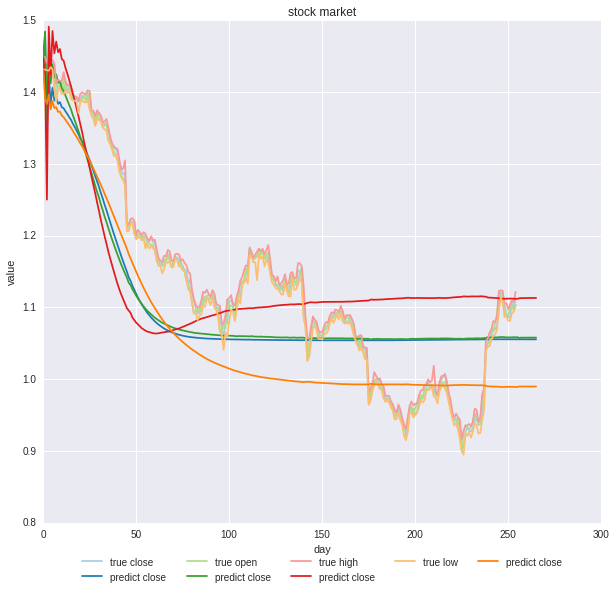

epoch: 200, loss: 0.00277526, speed: 0.790220975876 s / epoch


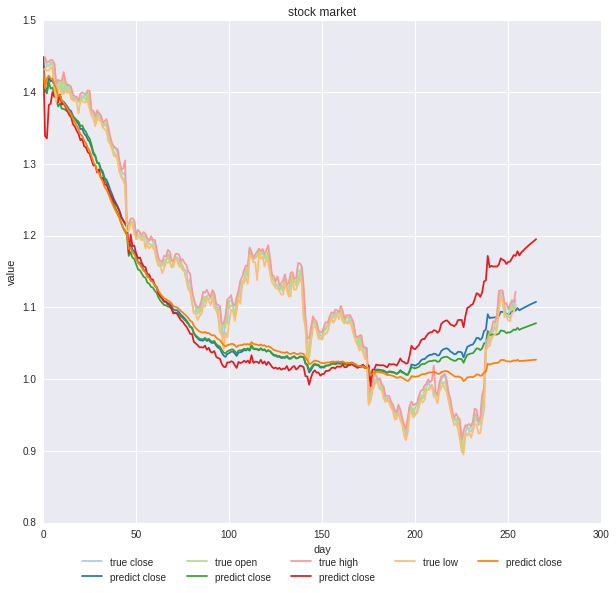

epoch: 300, loss: 0.000284363, speed: 1.02343416214 s / epoch


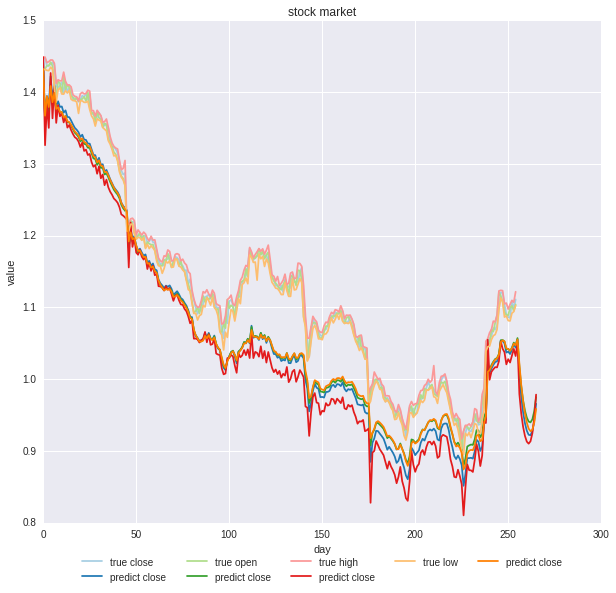

epoch: 400, loss: 0.000459258, speed: 1.2562661171 s / epoch


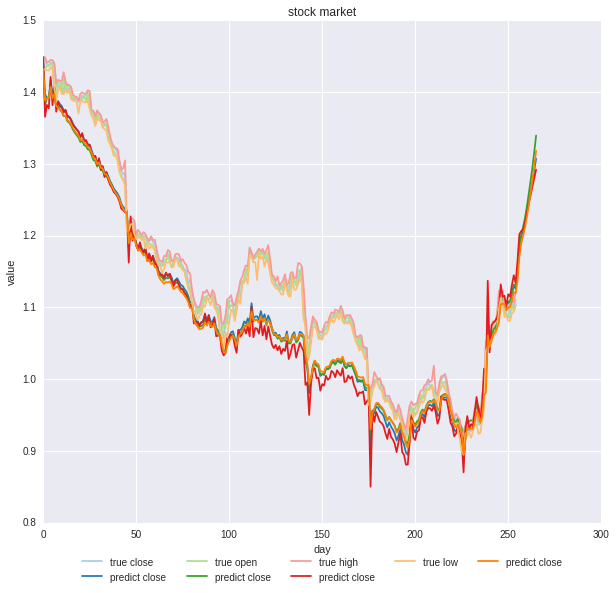

epoch: 500, loss: 0.00220691, speed: 1.10896992683 s / epoch


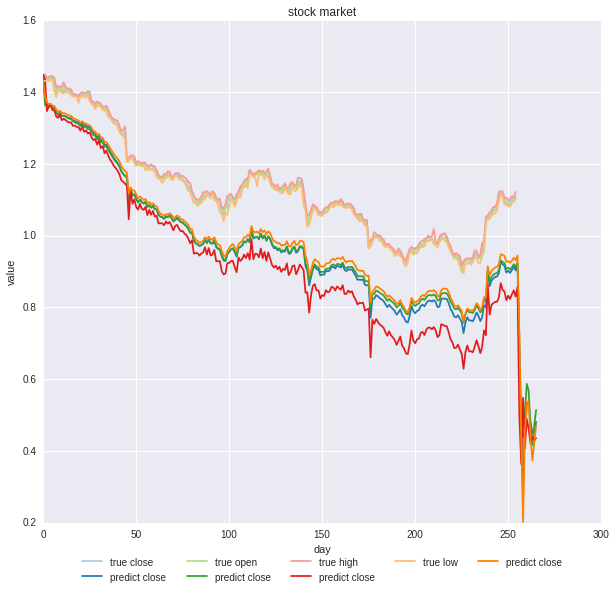

epoch: 600, loss: 3.01763e-05, speed: 0.702950000763 s / epoch


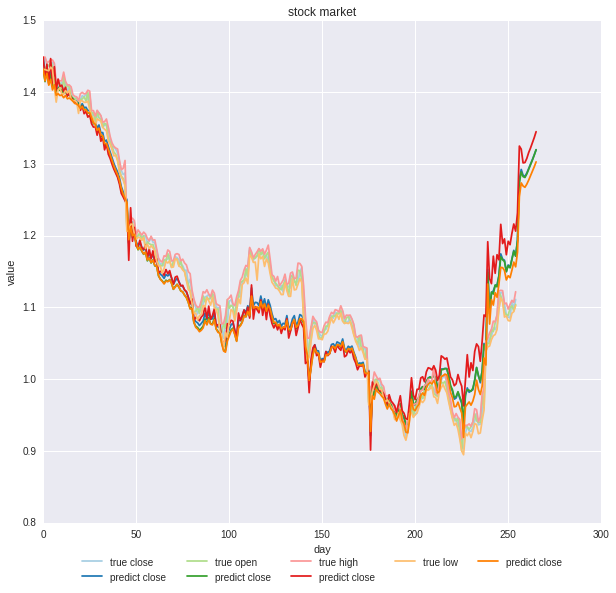

epoch: 700, loss: 0.000116646, speed: 1.21336078644 s / epoch


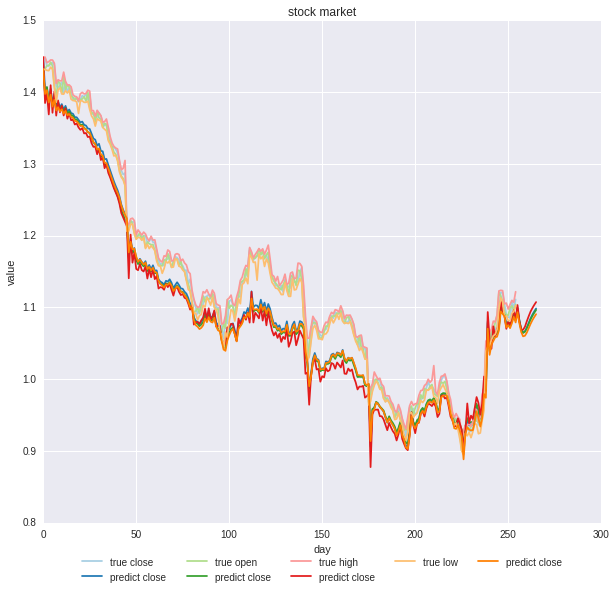

epoch: 800, loss: 4.95706e-05, speed: 1.83769917488 s / epoch


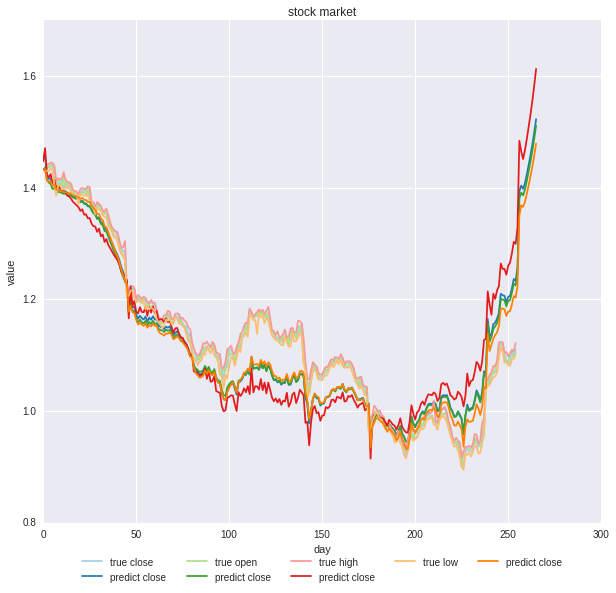

epoch: 900, loss: 0.000323329, speed: 0.678159952164 s / epoch


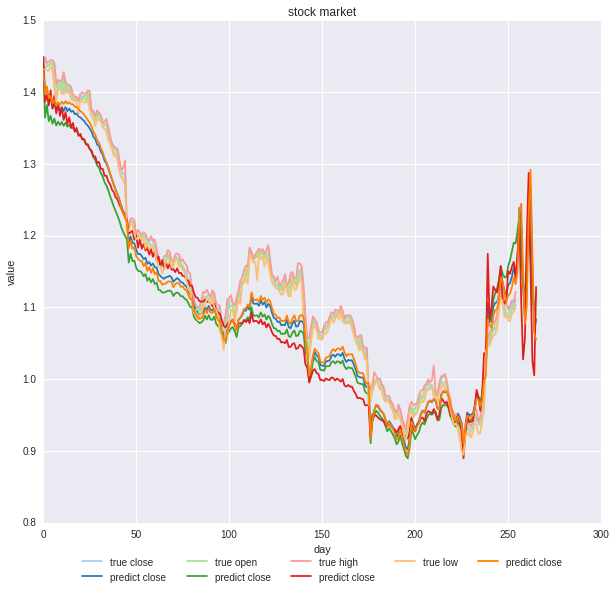

epoch: 1000, loss: 0.000135754, speed: 0.699757814407 s / epoch


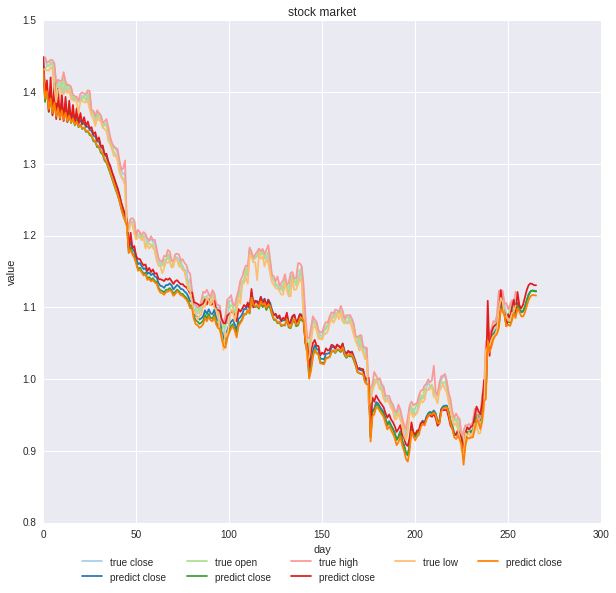

In [7]:
for i in xrange(epoch):
    last_time = time.time()
    init_value = np.zeros((1, num_layers * 2 * size_layer))
    for x in xrange(stockvals.shape[0] - 1):
        batch = np.zeros((1, 1, stockvals.shape[1]))
        batch_y = np.zeros((1, 1, stockvals.shape[1]))
        batch[0, :, :] = stockvals[x: x + 1, :]
        batch_y[0, :, :] = stockvals[x + 1: x + 2, :]
        last_state, _, loss = sess.run([modelnn.last_state, modelnn.optimizer, modelnn.cost], feed_dict = {modelnn.X: batch, modelnn.Y: batch_y, modelnn.hidden_layer: init_value})
        init_value = last_state
    diff = time.time() - last_time
    if (i + 1) % 100 == 0:
        print "epoch: " + str(i + 1) + ", loss: " + str(np.mean(loss)) + ", speed: " + str(diff) + " s / epoch"
        visualize_stock(stockvals, modelnn, num_layers, size_layer)